# Prática 6: Experimentos - Parte VI

### Kelvin Guilherme de Oliveira - 9293286
### Lucas Yudi Sugi - 9293251

O trabalho desenvolvido nessa atividade prática tem como objetivo realizar uma avaliação do algoritmo de classificação por meio da matriz de confusão.

Iremos continuar o trabalho desenvolvido na prática 5, na qual foi utilizado o dataset Breast Cancer.

## Dataset: Breast Cancer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Leitura do dataset com o pandas
dataset = pd.read_csv('./breast_cancer/wdbc.data',sep=',',header=None,encoding='latin1')

In [3]:
#Mostrando alguns elementos do dataset
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 1 - Atributos e Medida de Avaliação

Segundo as informações obtidas em https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names, temos que os atributos mais relevantes para a classificação são:

- mean texture
- worst area
- worst smoothness

Logo, essas características serão utilizadas para realizar a Classificação. Na avaliação do classificador, vamos considerar que uma pessoa com cancêr do tipo maligno corresponderá à classe positiva, e o câncer do tipo benigno será da classe negativa. Sendo assim, o que desejamos é que a taxa de falso positivo seja amenizada, pois do ponto de vista médico não é interessante classificar uma pessoa com câncer benigno de maligno, visto que isso não é saudável para o psicológico do paciente além de que o tratamento aplicado a pessoa causaria danos desnecessários a saúde.

In [4]:
#Extração dos atributos necesssários
breast_cancer = dataset.iloc[:,[5,13,16,1]]

#Renomeando as colunas
breast_cancer.columns = ['area','smoothness','texture','class']

#Mostrando novamente os dados
breast_cancer.head()

,area,smoothness,texture,class
0,1001.0,0.9053,0.006399,M
1,1326.0,0.7339,0.005225,M
2,1203.0,0.7869,0.006150,M
3,386.1,1.1560,0.009110,M
4,1297.0,0.7813,0.011490,M


Para que a classificação possua uma melhor acurácia iremos calcular as prababilidades balanceadas de cada classe para produzir melhores resultados.

In [5]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
    
    if not plot:
        return {'y_pred': y_pred, 'y_test':y_test}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

### 2 - Execução da Função

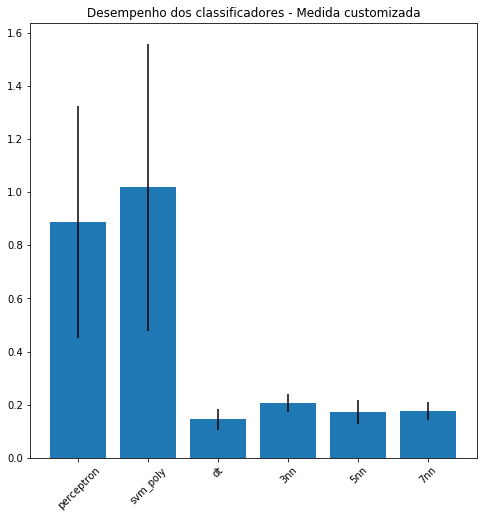

In [6]:
#Definindo função que penaliza a taxa de falso positivo
def pen_falso_positivo(y_true, y_pred):
    count = 0
    for i,j in enumerate(y_pred):
        if y_true[i] == 'B' and j == 'M':
            count += 2
        elif y_true[i] == 'M' and j == 'B':
            count += 1
    return count/len(y_true)
clf_custom = classificacao(breast_cancer,[0,1,2], 3, pen_falso_positivo, 'Medida customizada')

#### Escolha do classificador

Conforme o gráfico anterior note que todos os algoritmos possuem erros bem pequenos. Contudo, realizando uma comparação entre eles vemos que é possível descartar o perceptron e svm por serem relativamente "grandes" quando comparados com os demais.

Assim, devemos comparar os knn's com a árvore de decisão.

Com relação ao Knn's é perceptível que eles possuem desempenho muito semelhantes, porém como o 3nn possui uma complexidade menor por realizar menos cálculos, iremos decidir pelo 3nn ao invés do 5nn e 7nn.

Para comparar o 3nn com a árvore de decisão vamos analisar o gráfico de dispersão abaixo

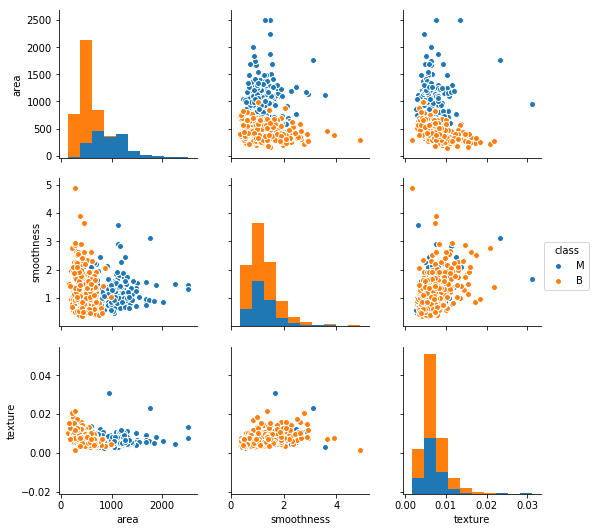

In [7]:
#Gráfico de dispersão por classe
sns.pairplot(breast_cancer,hue='class')
plt.show()

Note pelos gráficos que as classes podem ser consideradas linearmente separáveis de modo que apenas um corte no espaço pode conseguir distinguir bem os exemplos. Analisando-os vemos que cortes ortogonais (tipo de corte da árvore de decisão) permitem classificar bem o dataset. O 3nn também realiza isso porém com um pouco mais de dificuldade. 

Assim, a escolha do algoritmo dado essas análises é a <b>Arvore de Decisão</b>.

### 3 - Amostragem e Desempenho

Após verificar que o algoritmo Árvore de Decisão é o mais indicado para o nosso problema, nós iremos utilizar as seguintes técnicas de amostragem:

 - 10-fold Cross Validation
 - Leave-one-out
 - Bootstrap (1000 amostras de Bootstrap)
 
Isso será feito para verificar se o algoritmo possui um poder de generalização.

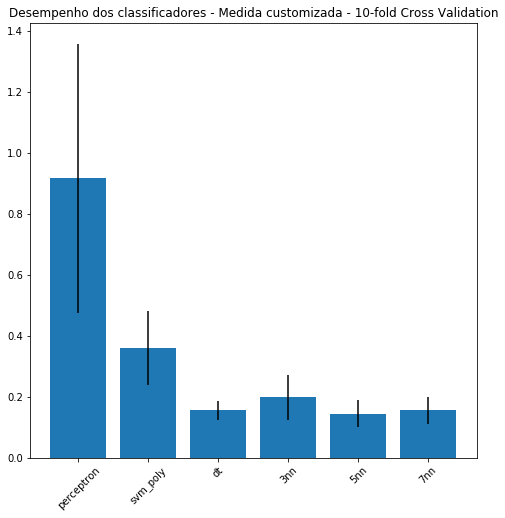

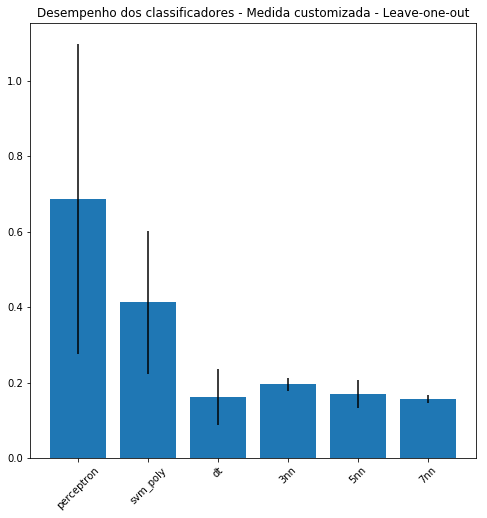

In [8]:
# 10-fold Cross Validation
clf_custom_cross_validation = classificacao(breast_cancer,[0,1,2], 3, pen_falso_positivo, 'Medida customizada - 10-fold Cross Validation', folds=10)

# Leave-one-out
clf_custom_leave_one_out = classificacao(breast_cancer,[0,1,2], 3, pen_falso_positivo, 'Medida customizada - Leave-one-out', folds=breast_cancer.shape[0])

In [9]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
def classificacao_bootstrap(bootstrap_dts, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(bootstrap_dts[0]), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(bootstrap_dts[0])*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')

    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']


    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for dt_boot in bootstrap_dts:

            # separa 80% para treino e 20% para teste
            test = dt_boot.sample(n=int(N_samples*0.2), replace=False)
            train = dt_boot.iloc[-test.index]

            # faz o treino do modelo
            clf = c.fit(X=train.iloc[:, columns], y=train.iloc[:, target])

            # valores predito pelo classificador
            y_pred = clf.predict(test.iloc[:, columns])
            # rótulos verdadeiros convertidos para array
            y_test = np.array(test.iloc[:, target])

            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )

    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}


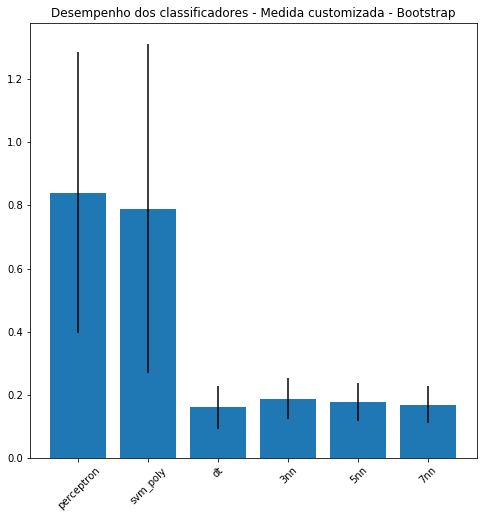

In [10]:
# Bootstrap
dt = breast_cancer.copy()
N_btp_samples = 1000
N_samples = dt.shape[0]
breast_cancer_dts = [dt.sample(n=N_samples, replace=True) for i in range(N_btp_samples)]

clf_boot_custom = classificacao_bootstrap(breast_cancer_dts,[0,1,2], 3, pen_falso_positivo, 'Medida customizada - Bootstrap')

### 4 - Matriz de confusão

In [11]:
#Classificando novamente para retornar os valores preditos e verdadeiros
clf = classificacao(breast_cancer,[0,1,2], 3, pen_falso_positivo, 'Acurácia - 10-fold Cross Validation', folds=10,plot=False)

#Criando a matriz de confusão
from sklearn.metrics import confusion_matrix
print(confusion_matrix(clf['y_test'], clf['y_pred']),'\n')
tn, fp, fn, tp = confusion_matrix(clf['y_test'], clf['y_pred']).ravel()

print('Taxa de verdadeiro negativo',tn)
print('Taxa de falso positivo',fp)
print('Taxa de falso negativo',fn)
print('Taxa de verdaeiro positivo',tp)

[[76  2]
 [ 7 28]] 

Taxa de verdadeiro negativo 76
Taxa de falso positivo 2
Taxa de falso negativo 7
Taxa de verdaeiro positivo 28


Para que seja possível escolhar o melhor classificador devemos inicialmente, antes até mesmo de toda análise exploratória dos dados, verificar qual o nosso objetivo. Sem um "lugar" para qual devemos chegar não é possível verificar qual o melhor algoritmo. Aliás, sem um objetivo não deveria-se nem mesmo começar o processo de ciências de dados.

Em nosso problema o que desejamos alcançar é um menor número de falsos positivos. Assim, o melhor algoritmo a ser escolhido é aquele que minimiza este valor. Quando isso ocorrer, caso haja mais de um que atinja essa métrica devemos pensar em termos mais técnicos qual o melhor para o problema.

Para isso, existe uma infinidade de possibilidades, mas características passíveis de análise são: tempo de processamento, memória gasta, algoritmo com maior poder de generalização, etc. Cabe ao desenvolvedor escolher aquele que além de melhor resolver o problema do cliente, seja capaz de atender as necessidades do mesmo.